# 基于CNN识别宠物脸部

### 下载数据
从这个地址中直接下载`https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz` ,不开vpn加载的很快，1-2分钟就好

然后解压，删除压缩包

In [ ]:
!tar -xf images.tar.gz

### 图片分类
现在下载的images下面，结构是`动物名_i.jpg`,现在考虑用pytorch中的Imagefolder函数，它会自动给图片贴上标签，需要传入一个目录文件夹，文件夹的格式是root/xxx类别/img,root下的子目录里是某一标签的所有image,所以现在要把images重新分类

In [12]:
import os
if not os.path.exists("Petfaces"):
    os.makedirs("Petfaces")
for filename in os.listdir("images"):#os.listdir可以列出其文件夹下的所有文件名
    if filename.endswith(".jpg"):
        list=filename.split("_")[:-1]#用[:-1]而不是[0],是因为有些名字是XXX_XXX_i.jpg
        petclass="_".join(list)# sep.join(list) 是在每个元素间插入sep,变成字符串
        petdir=os.path.join("Petfaces",petclass)

        if not os.path.exists(petdir):
            os.makedirs(petdir)

        os.rename(os.path.join("images",filename),os.path.join(petdir,filename))
        #os.rename(src,dst)移动某个文件

用Imagefolder时可以传入tansform，指定如何变化图片，这里只用了最简单的resize大小，和转为张量

In [26]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

transform=transforms.Compose([transforms.Resize((112,112)),
                              transforms.ToTensor(),
                             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

root="Petfaces"
dataset=ImageFolder(root,transform=transform)
pet_class=dataset.classes
classes_number=len(pet_class)
print(classes_number)

37


现在划分数据集为训练集和测试集，注意，dataloader是迭代器，不能用索引。

In [54]:
import torch
from torch.utils.data import DataLoader
train_size=int(len(dataset)*0.9)
test_size=len(dataset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[train_size,test_size])

train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True,num_workers=8)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=8)
dataloader=(train_dataloader,test_dataloader)


### 搭建网络
首先先确定网络的结构，输入是3,112,112,

第一次设想：
Conv(3，16)*2+pool   + Conv(16，32)*2+pool  + Conv(132，64)*2+pool +Conv(64，128)*2。用的kernel是5*5的。

偏传统的写法：5×5 → pool → 5×5 → pool，用大卷积核，快速降采样的方式勉强控制计算量。

现代写法：3×3 → 3×3 → pool，小核堆深慢慢扩大感受野，再有意识地下采样。

我这里犯了一个错误，两边好处都没捞着，参数很多 + 信息冗杂。其次是我没有用batchnorm2d，导致loss完全下降不下去。

In [53]:
import torch.nn as nn
class Net1(nn.Module):
    def __init__(self,num_classes):
        super(Net1,self).__init__()
        self.Conv=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=16),#新增
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=16),#新增
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #(16,56,56)

            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=32),#新增
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=32),#新增
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #(32,28,28)

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=64),#新增
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=64),#新增
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #(64,14,14)

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=128),#新增
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=1,stride=1,padding=1),
            nn.BatchNorm2d(num_features=128),#新增
            nn.ReLU(inplace=True),
            nn.Flatten(),
            #(128,14,14)
        )

        self.fc=nn.Sequential(
            nn.Linear(in_features=128*14*14,out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(in_features=512,out_features=num_classes),
        )

    def forward(self,x):
        x = self.Conv(x)
        x = self.fc(x)
        return x

重新设计网络，这次只用了三层。acc跑到29就停了

采用4层的结构效果更好，可以跑到42


In [57]:
import torch.nn as nn
class Net2(nn.Module):
    def __init__(self,num_classes):
        super(Net2,self).__init__()
        self.Conv1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
        )

        self.Conv2=nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
        )

        self.Conv3=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=64),#新增
            nn.ReLU(inplace=True),
        )

        self.Conv4=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )

        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*7*7,out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=512,out_features=num_classes),
        )

    def forward(self,x):
        x = self.maxpool(self.Conv1(x))#16，56，56
        x = self.maxpool(self.Conv2(x))#32，28，28
        x = self.maxpool(self.Conv3(x))#64，14，14
        x = self.maxpool(self.Conv4(x))#128,7,7
        x = self.fc(x)
        return x

### 测试和训练代码

In [ ]:
def top_k(predict,labels,k):
    _,predict_k=torch.topk(predict,k,dim=1)#会返回
    labels_1=labels.view(-1,1)
    result=torch.sum((predict_k==labels_1).any(dim=1))
    return result


### top_k的正确率
1. 用top_k得到value和索引
2. 将label扩维
3. 利用广播机制比较，然后用any函数查看一行中是否有满足的，最后统计

In [49]:
def validation(model,test_loader,device,loss_fn=nn.CrossEntropyLoss()):
    model.eval()
    model=model.to(device)
    test_loss=0
    correct=0
    correct_3=0
    test_size=0;
    with torch.no_grad():
        for i,(datas,labels) in enumerate(test_loader):
            datas=datas.to(device)
            labels=labels.to(device)
            output=model(datas)
            predict=torch.argmax(output,dim=1)
            correct_3+=top_k(output,labels,3)
            correct+=torch.sum(predict==labels).item()
            loss=loss_fn(output,labels)
            test_loss+=loss.item()
            test_size+=len(labels)

    return test_loss/len(test_loader),correct/test_size,correct_3/test_size

这里直接从框架中复制了,先是测试代码

In [50]:
epochs=30
global_step=0
from torch.utils.tensorboard import SummaryWriter

dataloader=(train_dataloader,test_dataloader)
def train_with_earlystop(model,dataloader,device,epochs,loss_fn=nn.CrossEntropyLoss(),optimizer):
    global global_step
    writer=SummaryWriter("./train_loss_log")

    train_dataloader, test_dataloader = dataloader
    patience=5
    min_loss=float("inf")
    checkpoint=None

    for epoch in range(epochs):
        model.train()

        for i,(datas,labels) in enumerate(train_dataloader):
            datas=datas.to(device)
            labels=labels.to(device)
            output=model(datas)
            output=output.squeeze(1)
            loss=loss_fn(output,labels)
            #清理梯度
            optimizer.zero_grad()
            #反向传播
            loss.backward()
            #更新权重
            optimizer.step()
            global_step+=1
            if i%10==0:
                print(f"epoch:{epoch}_{i},loss:{loss}")
                writer.add_scalar("trainLoss",loss,global_step)


        test_loss,acc,acc_3=validation(model,test_dataloader,device,loss_fn)
        writer.add_scalar("Test/Loss",test_loss,epoch)
        writer.add_scalar("Test/acc",acc,epoch)
        writer.add_scalar("Test/acc_3",acc_3,epoch)
        print(f"test_loss:{test_loss:.4f},acc:{acc:.4f},acc_3:{acc_3:.4f}")
        if test_loss<min_loss:
            min_loss=test_loss
            patience=5
            checkpoint={
                "epoch":epoch,
                "model_state_dict":model.state_dict(),
                "optimizer_state_dict":optimizer.state_dict(),
                "loss":min_loss,
            }
        else:
            patience-=1
        if patience<=0:
            print("Early stopping")
            break
    if checkpoint is not None:
        torch.save(checkpoint,f"./checkpoint/checkpoint_loss{min_loss}.pth")



训练代码

In [58]:
device="cuda" if torch.cuda.is_available() else "cpu"

model=Net2(classes_number).to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=5e-4)
train_with_earlystop(model, dataloader, device, epochs)

### 遇到的问题与总结
1. 第一次训练时，发现loss怎么都降不下去，是因为没用batchnorm2d,而且选择的网络结构错误,用了5*5+5*5+pool。
2. batch_size需要和数据量和网络结构相匹配。数据集很小，37*200，每个训练集就180张。我第一次较复杂的结构用512batch的时候，效果不好，用64batch的时候效果很好。

   这是因为小batch的噪声大，方向抖，大batch噪声小，方向稳，会与这一批次的样本抖尽量贴合，所以下降的很慢。
3. 参数量 × 有效样本数 = 过拟合强度。小数据集上，conv + conv + pool 往往比 conv + pool 更容易过拟合。不是因为它“学得更少”，而是因为它学得太精细、太确定。用一层conv+pool：参数少，特征快速抽象，空间信息早期被压缩，噪声被 pool 掉。
4. 如果我希望连续训练，应该不把优化器定义在函数内部,不然关于优化器的记忆会丢失。

总结一下，选择的网络结构和数据量应该要相关，batch_size也不是越大越好



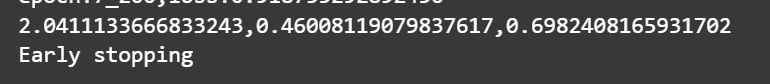

这是最终结果，acc差不多最高46%，top3正确率在69左右